MURA Pre-train

In [1]:
from keras import backend as K

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
input_size = (320, 320)
n_classes = 2

In [3]:
import h5py
import numpy as np

def import_from_hdf5(path):
  with h5py.File(path, "r", driver='core') as hdf5_file:

    train_data = None
    batch_begin, batch_end = 0, 200
    train_samples = len(hdf5_file['train_img'])
    while True:
      batch_end = min(batch_end, train_samples)
      batch = hdf5_file['train_img'][batch_begin:batch_end, :, :, :]
      if train_data is None:
        train_data = batch
      else:
        train_data = np.concatenate([train_data, batch], axis=0)
      print('Loaded', batch_end, 'samples of', train_samples, 'samples of train data')
      if batch_end == train_samples:
        break
      else:
        batch_begin = batch_end
        batch_end += 200

    train_labels = hdf5_file['train_labels'][:]
    
    valid_data = None
    batch_begin, batch_end = 0, 200
    val_samples = len(hdf5_file['val_img'])
    while True:
      batch_end = min(batch_end, val_samples)
      batch = hdf5_file['val_img'][batch_begin:batch_end, :, :, :]
      if valid_data is None:
        valid_data = batch
      else:
        valid_data = np.concatenate([valid_data, batch], axis=0)
      print('Loaded', batch_end, 'samples of', val_samples, 'samples of val data')
      if batch_end == val_samples:
        break
      else:
        batch_begin = batch_end
        batch_end += 200
    
    valid_labels = hdf5_file['val_labels'][:]

    train_data, valid_data = train_data[:, :, :, :], valid_data[:, :, :, :]
    
  return train_data, train_labels, valid_data, valid_labels

In [4]:
hand_train, hand_train_labels, hand_valid, hand_valid_labels = import_from_hdf5('data/hand.hdf5')

print(hand_train.shape, hand_train_labels.shape, hand_valid.shape, hand_valid_labels.shape)

Loaded 200 samples of 5543 samples of train data
Loaded 400 samples of 5543 samples of train data
Loaded 600 samples of 5543 samples of train data
Loaded 800 samples of 5543 samples of train data
Loaded 1000 samples of 5543 samples of train data
Loaded 1200 samples of 5543 samples of train data
Loaded 1400 samples of 5543 samples of train data
Loaded 1600 samples of 5543 samples of train data
Loaded 1800 samples of 5543 samples of train data
Loaded 2000 samples of 5543 samples of train data
Loaded 2200 samples of 5543 samples of train data
Loaded 2400 samples of 5543 samples of train data
Loaded 2600 samples of 5543 samples of train data
Loaded 2800 samples of 5543 samples of train data
Loaded 3000 samples of 5543 samples of train data
Loaded 3200 samples of 5543 samples of train data
Loaded 3400 samples of 5543 samples of train data
Loaded 3600 samples of 5543 samples of train data
Loaded 3800 samples of 5543 samples of train data
Loaded 4000 samples of 5543 samples of train data
Load

1 1 1 1 
0 0 0 1 
1 1 1 1 


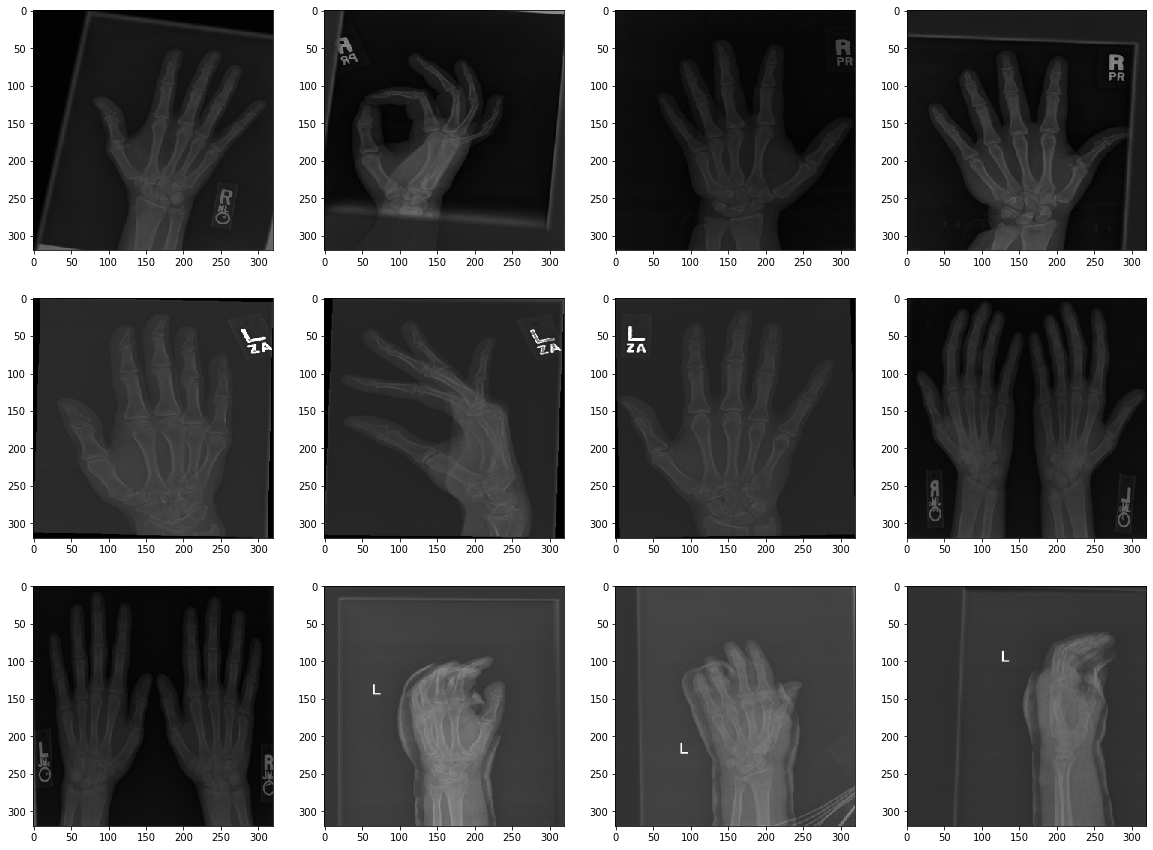

In [6]:
import matplotlib.pyplot as plt

shift = 1520
n_cols, n_rows = 4, 3

fig, ax = plt.subplots(figsize=(5 * n_cols, 5 * n_rows), ncols=n_cols, nrows=n_rows)

for i in range(n_rows):
  s = ''
  for k in range(n_cols):
    
    ax[i, k].imshow(hand_train[shift + i * n_cols + k].astype(np.uint8))
    s += str(hand_train_labels[shift + i * n_cols + k]) + ' '
  print(s)

plt.show()

In [7]:
#Model definition
import keras
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from keras.optimizers import adam

def get_compiled_model_instance(lr=0.001, beta1=0.9, beta2=0.999, label_smoothing=0.0):

  def loss(y_true, y_pred): #Wrapping a tf loss to the keras interface with only 2 args
    return binary_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

  def get_lr_metric(optimizer): #Custom metric to monitor learning rate
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

  base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=None, pooling='avg')

  x = base_model.output
  predictions = Dense(1, activation='sigmoid')(x)

  optimizer = adam(lr=lr, beta_1=beta1, beta_2=beta2)

  lr_metric = get_lr_metric(optimizer)

  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', lr_metric])

  return model

#get_compiled_model_instance()

In [8]:
#Data generators

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    featurewise_center = True, #Mean-shift
    featurewise_std_normalization = True, #Standardization
    horizontal_flip=True, #Augment
    vertical_flip=True,
    rotation_range=90,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    )

train_datagen.fit(hand_train)

valid_datagen = ImageDataGenerator( #Data standardization, no augment
    featurewise_center=True,
    featurewise_std_normalization = True,
)

valid_datagen.fit(hand_valid)

In [9]:
#Learning rate scheduler - reduce by factor 0.1 on plateau longer than 10 epochs

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=0.0001, verbose=1, min_lr=0.0000001)

In [10]:
#Class weights computing to penalize errors on more rare class

from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(hand_train_labels), hand_train_labels)

class_weight

array([0.68280365, 1.8675876 ])

In [29]:
#Modular live loss plotter for Keras models
#Allows to create custom layouts of per-batch or per-epoch plots for different metrics

#Monitor class defines a plot, which either may be batch or epoch-scoped, and may contain several graphs
#Batch monitor plots its values per batch, and refreshes itself on new epoch begin
#Epoch monitor plots its values per epoch, and performs no refresh
#All values/last N values displaying
#Log-scale/Linear scale displaying

#Plotter callback handles different Monitors and responds to the actual plotting
#Defines a grid where Monitors will be drawn, grid size, refresh rate in batches
#when the Monitors will be re-drawn in addition to per-epoch update
#Plotter can be silenced to disable plotting and only archivate per-epoch data

from IPython.display import clear_output
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class Monitor():
  def __init__(self, level='epoch', monitors= [ 'loss' ], plot_last=-1, log_scale=False):
    self.level = level.lower()
    self.monitors = [ monitor.lower() for monitor in monitors ]
    self.plot_last = max(0, plot_last)
    self.x = []
    self.ys = [ [] for monitor in monitors ]
    self.log_scale = log_scale

  def reinit(self):
    self.x = []
    self.ys = [ [] for monitor in self.monitors ]

  def update(self, iteration, logs={}):
    self.x.append(iteration)
    [ self.ys[i].append(logs.get(monitor)) for i, monitor in enumerate(self.monitors) ]

  def plot(self, axis):
    x_data = self.x[ -self.plot_last : ]
    y_array = [ y_data[ -self.plot_last : ] for y_data in self.ys ]

    for i, y_data in enumerate(y_array):
      label = self.monitors[i] + '_' + self.level
      if self.log_scale:
        axis.set_yscale('log')
      axis.plot(x_data, y_data, label=label)
      axis.legend()


class Plotter(Callback):
  def __init__(self, scale=5, n_cols=2, n_rows=1, monitors=[], refresh_rate=-1, silent=False):
    if (n_cols * n_rows < len(monitors)):
      raise ValueError('Grid is too small to fit all monitors!')

    self.n_cols = n_cols
    self.n_rows = n_rows
    self.scale = scale

    self.monitors = monitors

    self.batch_monitors, self.epoch_monitors = [], []

    for monitor in monitors:
      if monitor.level == 'epoch':
        self.epoch_monitors.append(monitor)
      elif monitor.level == 'batch':
        self.batch_monitors.append(monitor)

    self.refresh_rate = refresh_rate
    self.silent = False

  def on_train_begin(self, logs={}):
    pass

  def on_epoch_begin(self, epoch, logs={}):
    [ monitor.reinit() for monitor in self.batch_monitors ]

  def plot(self):
    clear_output(wait=True)

    figsize = ( self.scale * self.n_cols, self.scale * self.n_rows)
    fig, ax = plt.subplots(figsize=figsize, ncols=self.n_cols, nrows=self.n_rows)

    for i in range(self.n_rows):
      for k in range(self.n_cols):
        index = i * self.n_cols + k
        axis = ax[i, k]
        self.monitors[index].plot(axis)

    plt.show()

  def on_batch_end(self, batch, logs={}):
    [ monitor.update(batch, logs) for monitor in self.batch_monitors ]

    if self.silent or batch == 0 or self.refresh_rate <= 0 or batch % self.refresh_rate != 0:
      return

    self.plot()

  def on_epoch_end(self, epoch, logs={}):
    [ monitor.update(epoch, logs) for monitor in self.epoch_monitors ]

    if self.silent:
      return

    self.plot()
    
monitors = [
        Monitor(level='batch', monitors = ['loss']),
        Monitor(level='epoch', monitors = ['loss', 'val_loss']),
        Monitor(level='epoch', monitors = ['loss', 'val_loss'], plot_last=16),
        Monitor(level='batch', monitors = ['accuracy']),
        Monitor(level='epoch', monitors = ['accuracy', 'val_accuracy']),
        Monitor(level='epoch', monitors = ['lr'], log_scale=True), #lr represents custom metric defined to watch the learning rate
        ]

plot_losses = Plotter(monitors=monitors, n_rows=2, n_cols=3, refresh_rate=32)

In [19]:
class TextMonitor():
  def __init__(self, scope='epoch', monitors= [ 'loss' ], precision=4):
    self.scope = scope.lower()
    self.monitors = [ monitor.lower() for monitor in monitors ]
    self.precision = 4
    
  def output(self, logs={}):
    s = ''
    for monitor in self.monitors[:1]:
        value = logs.get(monitor)
        if value is not None:
            s += monitor + ': ' + str(round(value, self.precision))
    for monitor in self.monitors[1:]:
        value = logs.get(monitor)
        if value is not None:
            s +=', ' + monitor + ': ' + str(round(value, self.precision))
    print(s)
    
class TextInfo(Callback):
  def __init__(self, monitors=[], refresh_rate=-1):
    
    self.monitors = monitors
    self.batch_monitors, self.epoch_monitors = [], []

    for monitor in monitors:
      if monitor.scope == 'epoch':
        self.epoch_monitors.append(monitor)
      elif monitor.scope == 'batch':
        self.batch_monitors.append(monitor)

    self.refresh_rate = refresh_rate
    self.silent = False
    self.epoch = -1

  def on_train_begin(self, logs={}):
    pass

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch = epoch

  def on_batch_end(self, batch, logs={}):
    if batch == 0 or self.refresh_rate <= 0 or batch % self.refresh_rate != 0:
      return

    print('Batch', batch, 'of epoch', self.epoch)
    [ monitor.output(logs) for monitor in self.batch_monitors ]

  def on_epoch_end(self, epoch, logs={}):
    print('Epoch', epoch, 'end')
    [ monitor.output(logs) for monitor in self.epoch_monitors ]
    
#monitors = [
#        Monitor(level='batch', monitors = ['loss']),
#        Monitor(level='epoch', monitors = ['loss', 'val_loss']),
#        Monitor(level='epoch', monitors = ['loss', 'val_loss'], plot_last=16),
#        Monitor(level='batch', monitors = ['acc']),
#        Monitor(level='epoch', monitors = ['acc', 'val_acc']),
#        Monitor(level='epoch', monitors = ['lr'], log_scale=True), #lr represents custom metric defined to watch the learning rate
#        ]


In [20]:
class EpochCounter(Callback): #Used to count global epochs number passed during multiple training launches
  def __init__(self, initial_epoch=0):
    self.epoch = initial_epoch

  def on_epoch_end(self, epoch, logs={}):
    self.epoch += 1

epoch_counter = EpochCounter()

In [21]:
#TensorBoard as an advanced tool to watch the learning process

#%load_ext tensorboard.notebook

#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

#tbc=TensorBoardColab()

In [22]:
from keras.callbacks import ModelCheckpoint #Mandatory for a long-time training

filepath="models/dn121-mura-pretrain-{epoch:03d}-{val_loss:.4f}-{lr:.7f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=10)


In [30]:
callbacks = [
             checkpoint,
             reduce_lr,
             plot_losses,
             #text_output,
             epoch_counter,
             #TensorBoardColabCallback(tbc),
             ]

In [24]:
hand_model = get_compiled_model_instance()

In [31]:
#Launch primary model training

batch_size = 8
val_batch_size = 256
epochs = 200

hand_model.fit_generator(train_datagen.flow(hand_train, hand_train_labels, batch_size=batch_size, shuffle=True),
                         validation_data=valid_datagen.flow(hand_valid, hand_valid_labels, batch_size = val_batch_size, shuffle=True), #Validation set is used only at the epoch end
                         class_weight=class_weight,
                         epochs=epochs,
                         callbacks=callbacks,
                         initial_epoch=epoch_counter.epoch,
                         verbose=2)

MemoryError: Unable to allocate array with shape (5543, 320, 320, 3) and data type float32